In [1]:
import os
import numpy as np
import pandas as pd
import librosa
import sounddevice as sd
import scipy.io.wavfile as wav
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import joblib
from datetime import datetime
import matplotlib.pyplot as plt



In [2]:
!pip install sounddevice


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
# Install the PortAudio development library
!apt-get update
!apt-get install -y libportaudio2 portaudio19-dev


'apt-get' is not recognized as an internal or external command,
operable program or batch file.
'apt-get' is not recognized as an internal or external command,
operable program or batch file.


In [4]:
EMOTIONS = {
    '01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad',
    '05': 'angry', '06': 'fearful', '07': 'disgust', '08': 'surprised'
}

In [5]:
def extract_features(file_path):
    y, sr = librosa.load(file_path, duration=3, offset=0.5)
    mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(y=y, sr=sr).T, axis=0)
    mel = np.mean(librosa.feature.melspectrogram(y=y, sr=sr).T, axis=0)
    return np.hstack([mfccs, chroma, mel])


In [6]:
def load_data(data_path):
    X, y = [], []
    for root, _, files in os.walk(data_path):
        for file in files:
            if file.endswith('.wav'):
                file_path = os.path.join(root, file)
                emotion_code = file.split('-')[2]
                emotion = EMOTIONS.get(emotion_code)
                features = extract_features(file_path)
                X.append(features)
                y.append(emotion)
    return np.array(X), np.array(y)

# Set your RAVDESS path
data_path = r"C:\Users\Ravindra\Downloads\ravdess (1)"
X, y = load_data(data_path)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))

# Save model
joblib.dump(model, 'emotion_model.pkl')

Accuracy: 0.9097222222222222


['emotion_model.pkl']

In [2]:
print(f"Number of samples loaded: {len(X)}")

NameError: name 'X' is not defined

In [1]:
def record_voice(filename='recorded.wav', duration=3, fs=44100):
    print("Recording...")
    audio = sd.rec(int(duration * fs), samplerate=fs, channels=1)
    sd.wait()
    wav.write(filename, fs, audio)

record_voice()

# Extract features and predict
features = extract_features('recorded.wav').reshape(1, -1)
model = joblib.load('emotion_model.pkl')
predicted_emotion = model.predict(features)[0]
print(f"Predicted Emotion: {predicted_emotion}")


Recording...


NameError: name 'sd' is not defined

In [10]:
log_file = 'session_log.csv'
log_entry = pd.DataFrame([[datetime.now(), predicted_emotion]], columns=["Timestamp", "Emotion"])

if not os.path.exists(log_file):
    log_entry.to_csv(log_file, index=False)
else:
    log_entry.to_csv(log_file, mode='a', header=False, index=False)


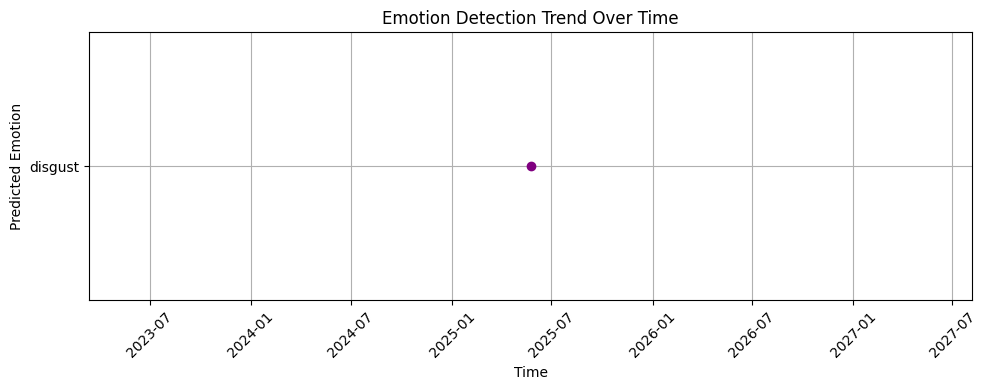

In [11]:
import matplotlib.pyplot as plt

# Load the log
log_data = pd.read_csv('session_log.csv')
log_data['Timestamp'] = pd.to_datetime(log_data['Timestamp'])

# Set timestamp as index
log_data.set_index('Timestamp', inplace=True)

# Plot emotional trend
plt.figure(figsize=(10, 4))
plt.plot(log_data.index, log_data['Emotion'], marker='o', linestyle='-', color='purple')
plt.title("Emotion Detection Trend Over Time")
plt.xlabel("Time")
plt.ylabel("Predicted Emotion")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()
